We start with a simple example:
Airy function


In [1]:
using DifferentialEquations
using QuadGK
using ForwardDiff
# using SymEngine;
using SymPy;
using LinearAlgebra;
using Plots
using ProgressMeter

The (complexified) Airy action is given by:
$$
S = - i (\frac{z^2}{3} + a z)
$$

In [2]:
SymPy.@vars z a;
SymPy.@vars x y real=true;
airy_action = - im*( z^3/3 + a*z )

   ⎛       3⎞
   ⎜      z ⎟
-ⅈ⋅⎜a⋅z + ──⎟
   ⎝      3 ⎠

We have two critical points at $  z = \pm \sqrt{-a}$

In [3]:
cri_sol=SymPy.solve(diff(airy_action,z),:z)

2-element Vector{Sym}:
 -sqrt(-a)
  sqrt(-a)

The critical action

In [4]:
cri_act = [airy_action.subs(z,cri_sol[1]).simplify(), airy_action.subs(z,cri_sol[2]).simplify()]

2-element Vector{Sym}:
 -2*I*(-a)^(3/2)/3
  2*I*(-a)^(3/2)/3

The SA flow equation is given by 
$$
\frac{\mathrm{d} x}{\mathrm{d}t} = \frac{\mathrm{d} \Re S}{\mathrm{d} x} \\
\frac{\mathrm{d} y}{\mathrm{d}t} = \frac{\mathrm{d} \Re S}{\mathrm{d} y}
$$

In [5]:
sa_eq_sym=diff.(real(airy_action.subs(z,x+im*y)),[x,y])

2-element Vector{Sym}:
     2⋅x⋅y + im(a)
 x^2 - y^2 + re(a)

In [6]:
hessian_sym = diff.(airy_action,z,z).subs(z,x+im*y)

-2⋅ⅈ⋅(x + ⅈ⋅y)

The real form of the Hessian matrix

In [7]:
re_Hessian_sym = sa_eq_sym.jacobian([x,y])

2×2 Matrix{Sym}:
 2⋅y   2⋅x
 2⋅x  -2⋅y

In [8]:
reHessian = Matrix([real(hessian_sym) -imag(hessian_sym);-imag(hessian_sym) -real(hessian_sym)])

2×2 Matrix{Sym}:
 2⋅y   2⋅x
 2⋅x  -2⋅y

Now we define the numerical function for the SA equation and Hessian matrix

In [9]:
airy_fn = eval(Expr(:function, Expr(:call, gensym(), [:x,:y,:a]...), convert.(Expr, airy_action.subs(z,x+im*y))))

sa_eq_0 = convert.(Expr, sa_eq_sym);

sa_eq_fn = map(x -> eval(Expr(:function, Expr(:call, gensym(), [:x,:y,:a]...), x)),sa_eq_0);

function sa_equation!(dv,v,paras,t)
    a = paras;
    x,y=v;
    map!(ff->ff(x,y,a),dv, sa_eq_fn);
    return nothing;
end

jac_fn = eval(Expr(:function, Expr(:call, gensym(), [:x,:y,:a]...), convert.(Expr, conj(hessian_sym))));

We do some test run, and here we choose $a = 1$, you can try other values

In [10]:
test_dv =test_v = [1.0,1.0]
test_a = 1
t0=0.0
@time sa_equation!(test_dv,test_v,test_a,t0)
test_dv

  0.046035 seconds (74.52 k allocations: 4.253 MiB, 99.59% compilation time)


2-element Vector{Float64}:
 2.0
 1.0

Remember we have two solutions from the critical equation, but actually only one will contribute from the asymptotic boundary condition, as we can see from the flowing plot

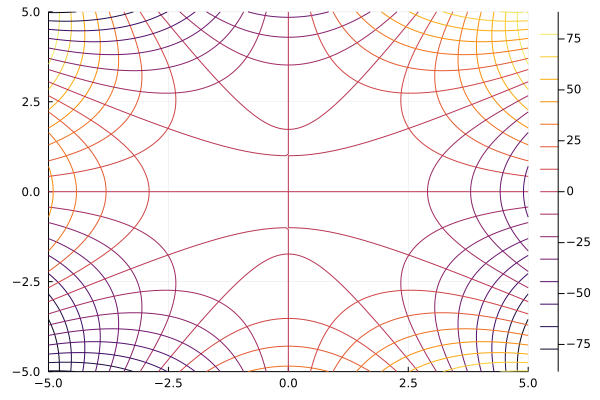

In [13]:
pc=contour(-5:0.05:5,-5:0.05:5,(x,y)->real(airy_fn(x,y,test_a)))
contour!(-5:0.05:5,-5:0.05:5,(x,y)->imag(airy_fn(x,y,test_a)))

In [19]:
solx1,soly1 = reim(N(cri_sol[1].subs(a,test_a).evalf()));
solx2,soly2 = reim(N(cri_sol[2].subs(a,test_a).evalf()))
solx,soly = solx2,soly2

(0.0, 1.0)

In [15]:
eigval,eigenvs1 = eigen(SymPy.N(reHessian.evalf(subs=Dict(x=>solx,y=>soly))))

Eigen{Float64, Float64, Matrix{Float64}, Vector{Float64}}
values:
2-element Vector{Float64}:
 -2.0
  2.0
vectors:
2×2 Matrix{Float64}:
 0.0  1.0
 1.0  0.0

In [16]:
eigenv1=eigenvs1[:,2]

2-element Vector{Float64}:
 1.0
 0.0

Now we use DifferentialEquations package to solve the SA flow equation.

We define it using the ODEProblem interface, and we set a condition to exclude the case when z (here u) flows too far away

In [20]:
condition(u,t,integrator) = norm(u) > 100
affect!(integrator) = terminate!(integrator)
cb = DiscreteCallback(condition,terminate!)
prob = ODEProblem(sa_equation!,[solx,soly] + 0 * eigenv1,(0.0,16),test_a,callback=cb)

ODEProblem with uType Vector{Float64} and tType Float64. In-place: true
timespan: (0.0, 16.0)
u0: 2-element Vector{Float64}:
 0.0
 1.0

We can make some test run, e.g. critical points do not flow.

In [21]:
sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8);
sol[end]

2-element Vector{Float64}:
 0.0
 1.0

Here we also define the flow of Jacobian. We have two ways:

1. Solve the Jacobian flow equation using solutions above
2. Use approximate estimate.
   
Let's use approximation first. Actually here when $a = 1$ our eigen vector is real!, so we know the solution $J(t) = \int dt \bar{H}(z(t))$




In [24]:
jac_func = (x) -> jac_fn(x[1],x[2],test_a)
det_jac_func= (x) -> det(jac_fn(x[1],x[2],test_a))
jac_i = sol -> exp(quadgk(x -> jac_func(sol(x)), 0, sol.t[end], rtol=1e-8)[1])

#31 (generic function with 1 method)

In [25]:
@time log(jac_i(sol))

  3.293449 seconds (6.55 M allocations: 404.198 MiB, 4.64% gc time, 99.97% compilation time)


32.0 + 0.0im

Now we do some test run's to see the approximated thimble we generated using SA flow. We choose $V_{\sigma}$ in the region $(-10^{(-12)},10^{(-12)})$ 

In [33]:
function prob_func(prob,i,repeat)
    @. prob.u0 = [solx,soly] + 10^(-12)*(-0.5+randn()) * eigenv1
    prob
end

prob_func (generic function with 1 method)

In [34]:
ensemble_prob = EnsembleProblem(prob,prob_func=prob_func,output_func = (sol,i) -> ((sol[1],sol[end]),false))

EnsembleProblem with problem ODEProblem

In [35]:
ss=solve(ensemble_prob,Tsit5();trajectories=1000);

In [36]:
ss1 = [norm(ll[1]) < 100 ? ll[2] : nothing for ll in ss];
filter!(x -> x!=nothing,ss1);
ss2=reshape(vcat(ss1...),(2,:));

It will look very nice

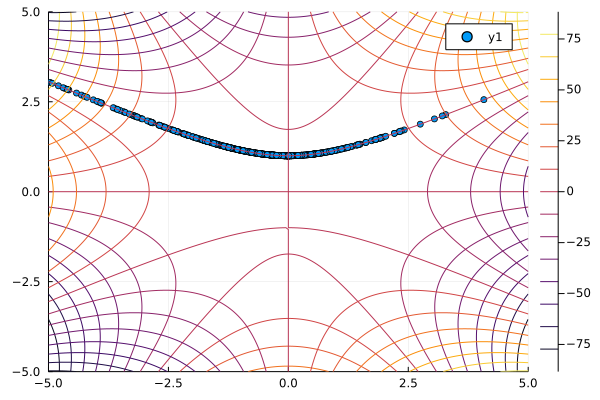

In [40]:
pl1=scatter(ss2[1,:],ss2[2,:],xlims=(-5,5), ylims = (-5,5))
contour!(-5:0.05:5,-5:0.05:5,(x,y)->real(airy_fn(x,y,test_a)))
contour!(-5:0.05:5,-5:0.05:5,(x,y)->imag(airy_fn(x,y,test_a)))

### MCMC method

With both the flow equation and the Jacobian equation, we can define the effective action

In [45]:
function effective_action(prob,det_Hess_fun,action_fun,ob_fun,ini0)
    prob1=remake(prob; u0=ini0 )
    sol = solve(prob1, Tsit5(), reltol=1e-10, abstol=1e-10)
    det_j_r=det_Hess_fun(sol)
    action_r = action_fun(sol[end])
    ob_r = ob_fun(sol[end])

    return (real(action_r ) - log(abs(det_j_r)) ,action_r ,  ob_r, sol[end] )
end


effective_action (generic function with 1 method)

In [46]:
np=ini0 -> effective_action(prob,jac_i,x->airy_fn(x...,test_a),x-> x[1] + im*x[2],ini0)

#59 (generic function with 1 method)

In [47]:
@time np([solx,soly]+ 10^(-12)*rand()*eigenv1)

  0.086867 seconds (139.27 k allocations: 7.749 MiB, 98.67% compilation time)


(358153.2476774158, 358186.0509263328 - 2.6080329007527325e-9im, 88.69501421700342 + 51.2178534853956im, [88.69501421700342, 51.2178534853956])

A simple MCMC example

In [49]:
test_re=[]

Any[]

In [50]:
function MCMC(num,skip)
    total_num = 0
    x0=[solx,soly]
    re=[]
    j=1
    p = Progress(num+skip, 1)
    while length(re) < num 
        while true
            x_r=10^(-12)*(-1/2+rand())
            x_1 = [solx,soly] + x_r*eigenv1
            p_j,aa_j,o_j,sol_j = np(x_1)
            p_i,aa_i,o_i,sol_i= np(x0)
            alpha = min(exp(-p_j) / exp(-p_i), 1.0)
            r = rand()
            total_num+=1
            if r <= alpha
                x_0 = x_1
                if j >= skip
                    push!(re,(p_j,o_j,x_r,sol_j,aa_j))
                end
                j += 1
                next!(p)
                break
            end
        end
    end
    print((num+skip)/total_num)
    return re
    
end


MCMC (generic function with 1 method)

In [51]:
test_re=MCMC(3000,3000);

Progress:   1%|▍                                        |  ETA: 0:01:54

Progress:   8%|███▏                                     |  ETA: 0:01:51

Progress:   9%|███▌                                     |  ETA: 0:01:51

Progress:  10%|███▉                                     |  ETA: 0:01:48

Progress:  11%|████▍                                    |  ETA: 0:01:44

Progress:  12%|████▉                                    |  ETA: 0:01:41

Progress:  13%|█████▎                                   |  ETA: 0:01:39

Progress:  14%|█████▋                                   |  ETA: 0:01:37

Progress:  15%|██████                                   |  ETA: 0:01:36

Progress:  16%|██████▌                                  |  ETA: 0:01:35

Progress:  17%|██████▉                                  |  ETA: 0:01:32

Progress:  18%|███████▍                                 |  ETA: 0:01:31

Progress:  19%|███████▉                                 |  ETA: 0:01:29

Progress:  20%|████████▎                                |  ETA: 0:01:28

Progress:  21%|████████▊                                |  ETA: 0:01:27

Progress:  22%|█████████▏                               |  ETA: 0:01:25

Progress:  23%|█████████▋                               |  ETA: 0:01:23

Progress:  24%|██████████                               |  ETA: 0:01:21

Progress:  26%|██████████▌                              |  ETA: 0:01:20

Progress:  27%|██████████▉                              |  ETA: 0:01:19

Progress:  28%|███████████▍                             |  ETA: 0:01:18

Progress:  29%|███████████▉                             |  ETA: 0:01:16

Progress:  30%|████████████▎                            |  ETA: 0:01:15

Progress:  31%|████████████▊                            |  ETA: 0:01:14

Progress:  32%|█████████████▏                           |  ETA: 0:01:13

Progress:  33%|█████████████▌                           |  ETA: 0:01:12

Progress:  34%|█████████████▉                           |  ETA: 0:01:11

Progress:  35%|██████████████▍                          |  ETA: 0:01:09

Progress:  36%|██████████████▉                          |  ETA: 0:01:08

Progress:  37%|███████████████▎                         |  ETA: 0:01:07

Progress:  38%|███████████████▋                         |  ETA: 0:01:06

Progress:  39%|████████████████▏                        |  ETA: 0:01:05

Progress:  40%|████████████████▌                        |  ETA: 0:01:04

Progress:  41%|████████████████▉                        |  ETA: 0:01:03

Progress:  42%|█████████████████▎                       |  ETA: 0:01:02

Progress:  43%|█████████████████▊                       |  ETA: 0:01:01

Progress:  44%|██████████████████▏                      |  ETA: 0:01:00

Progress:  45%|██████████████████▌                      |  ETA: 0:00:59

Progress:  46%|██████████████████▉                      |  ETA: 0:00:58

Progress:  47%|███████████████████▏                     |  ETA: 0:00:58

Progress:  48%|███████████████████▌                     |  ETA: 0:00:57

Progress:  48%|███████████████████▉                     |  ETA: 0:00:56

Progress:  50%|████████████████████▎                    |  ETA: 0:00:55

Progress:  51%|████████████████████▊                    |  ETA: 0:00:53

Progress:  52%|█████████████████████▏                   |  ETA: 0:00:52

Progress:  53%|█████████████████████▋                   |  ETA: 0:00:51

Progress:  54%|██████████████████████                   |  ETA: 0:00:50

Progress:  55%|██████████████████████▍                  |  ETA: 0:00:49

Progress:  56%|██████████████████████▉                  |  ETA: 0:00:48

Progress:  57%|███████████████████████▍                 |  ETA: 0:00:46

Progress:  58%|███████████████████████▉                 |  ETA: 0:00:45

Progress:  59%|████████████████████████▎                |  ETA: 0:00:44

Progress:  60%|████████████████████████▋                |  ETA: 0:00:43

Progress:  61%|█████████████████████████                |  ETA: 0:00:42

Progress:  62%|█████████████████████████▌               |  ETA: 0:00:41

Progress:  63%|█████████████████████████▉               |  ETA: 0:00:40

Progress:  64%|██████████████████████████▍              |  ETA: 0:00:38

Progress:  65%|██████████████████████████▊              |  ETA: 0:00:37

Progress:  66%|███████████████████████████▎             |  ETA: 0:00:36

Progress:  67%|███████████████████████████▋             |  ETA: 0:00:35

Progress:  68%|████████████████████████████▏            |  ETA: 0:00:34

Progress:  70%|████████████████████████████▌            |  ETA: 0:00:33

Progress:  71%|████████████████████████████▉            |  ETA: 0:00:32

Progress:  72%|█████████████████████████████▍           |  ETA: 0:00:31

Progress:  73%|█████████████████████████████▊           |  ETA: 0:00:29

Progress:  74%|██████████████████████████████▏          |  ETA: 0:00:28

Progress:  74%|██████████████████████████████▌          |  ETA: 0:00:27

Progress:  76%|███████████████████████████████          |  ETA: 0:00:26

Progress:  77%|███████████████████████████████▌         |  ETA: 0:00:25

Progress:  78%|███████████████████████████████▉         |  ETA: 0:00:24

Progress:  79%|████████████████████████████████▎        |  ETA: 0:00:23

Progress:  80%|████████████████████████████████▋        |  ETA: 0:00:22

Progress:  80%|█████████████████████████████████        |  ETA: 0:00:21

Progress:  82%|█████████████████████████████████▍       |  ETA: 0:00:20

Progress:  82%|█████████████████████████████████▊       |  ETA: 0:00:19

Progress:  83%|██████████████████████████████████▎      |  ETA: 0:00:18

Progress:  84%|██████████████████████████████████▋      |  ETA: 0:00:17

Progress:  85%|██████████████████████████████████▉      |  ETA: 0:00:16

Progress:  86%|███████████████████████████████████▎     |  ETA: 0:00:15

Progress:  87%|███████████████████████████████████▊     |  ETA: 0:00:14

Progress:  88%|████████████████████████████████████▏    |  ETA: 0:00:13

Progress:  89%|████████████████████████████████████▌    |  ETA: 0:00:12

Progress:  90%|████████████████████████████████████▉    |  ETA: 0:00:11

Progress:  91%|█████████████████████████████████████▍   |  ETA: 0:00:10

Progress:  92%|█████████████████████████████████████▊   |  ETA: 0:00:09

Progress:  93%|██████████████████████████████████████▏  |  ETA: 0:00:08

Progress:  94%|██████████████████████████████████████▌  |  ETA: 0:00:07

Progress:  95%|██████████████████████████████████████▉  |  ETA: 0:00:06

Progress:  96%|███████████████████████████████████████▏ |  ETA: 0:00:05

Progress:  97%|███████████████████████████████████████▋ |  ETA: 0:00:04

Progress:  98%|████████████████████████████████████████ |  ETA: 0:00:03

Progress:  99%|████████████████████████████████████████▌|  ETA: 0:00:01

Progress: 100%|█████████████████████████████████████████|  ETA: 0:00:00

0.05317169139150316

In [52]:
px_data = [xx[1] for xx in test_re];
ox_data = [xx[2] for xx in test_re];
x_r_data = [xx[3] for xx in test_re];
sol_j_data = [xx[4] for xx in test_re];
aa_j_data = [xx[5] for xx in test_re];

In [60]:
ss2_mc=reshape(vcat(sol_j_data...),(2,:));

In [56]:
amp_data=hcat(sort([[x_r_data[i],exp(-real(aa_j_data[i]))] for i in 1:length(x_r_data) ],by = x->x[1])...);

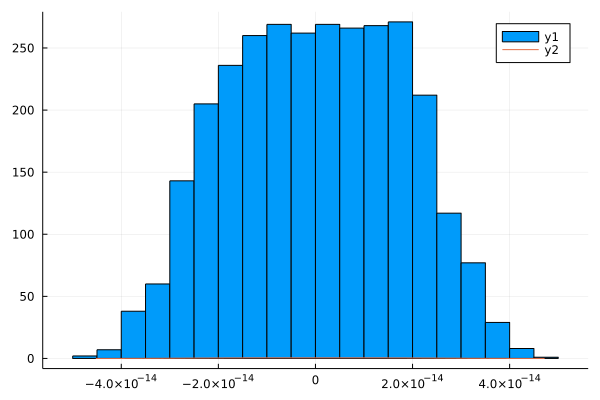

In [65]:

histogram(x_r_data)

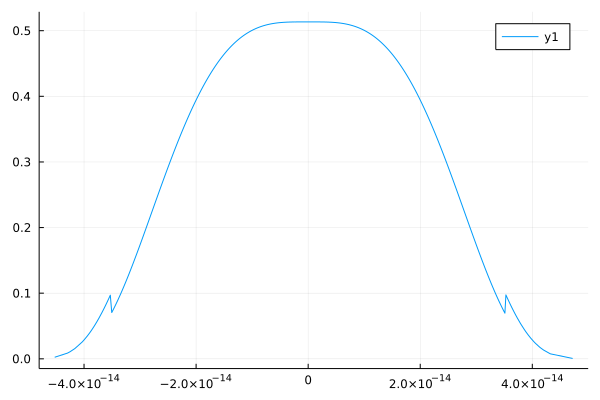

In [66]:
plot(amp_data[1,:],amp_data[2,:])

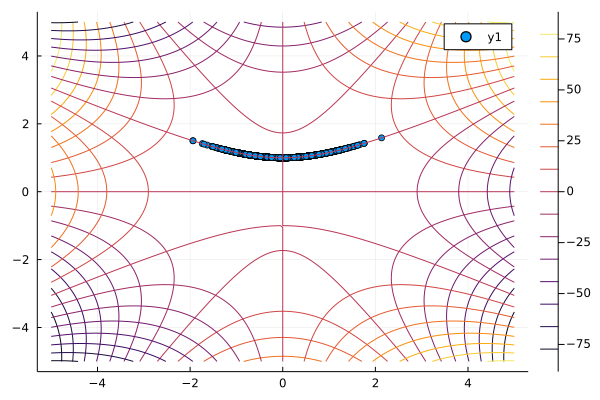

In [69]:
scatter(ss2_mc[1,:],ss2_mc[2,:])
contour!(-5:0.05:5,-5:0.05:5,(x,y)->real(airy_fn(x,y,test_a)))
contour!(-5:0.05:5,-5:0.05:5,(x,y)->imag(airy_fn(x,y,test_a)))